<a href="https://colab.research.google.com/github/j2cry/hw_DataSciencePyLibs/blob/main/MirzoianPeter_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO:

In [187]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Prepare environment**

In [188]:
!pip install catboost

In [189]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import rv_discrete

from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
from catboost import CatBoostClassifier, sum_models, to_classifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score as f1
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics import plot_roc_curve

PATH_TRAIN = '/content/drive/MyDrive/DS_part2/course_project_train.csv'
PATH_TEST = '/content/drive/MyDrive/DS_part2/course_project_test.csv'

In [190]:
import warnings
warnings.filterwarnings('ignore')

## Additional functions

In [191]:
def reduce_mem_usage(df, silent=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    if not silent:
      print(f'Memory usage of dataframe is {round(start_mem,2)} MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    if not silent:
      print(f'Memory usage of dataframe is {round(end_mem,2)} MB')
      print(f'Decreased by {round(100 * (start_mem - end_mem) / start_mem,1 )}%')
    
    return df

# import train data
def load_dataset(path, with_index=None, silent=False):
  data = pd.read_csv(path, index_col=with_index)
  return reduce_mem_usage(data, silent)

In [192]:
def overview(field: str, **kwargs):
  """ kwargs:
        'zero'=True: add zero-line to plot
        'median'=True: add median to plot
        'mean'=True: add mean to plot
        'mode'=True: add mean to plot
        'bins'--> bins
  """
  size = kwargs.get('size') if kwargs.get('size') else (14, 4)
  fig, ax = plt.subplots(1, 2, figsize=size, gridspec_kw={'width_ratios': [.7, .3]})
  ax[0].plot(data[field].reset_index(drop=True))
  if kwargs.get('zero'):
    ax[0].plot(np.linspace(0, data.shape[0], 2), [0] * 2, linewidth=1, color='red', label='zero')
  if kwargs.get('median'):
    ax[0].plot(np.linspace(0, data.shape[0], 2), [data[field].median()] * 2, linewidth=1, label='median')
  if kwargs.get('mean'):
    ax[0].plot(np.linspace(0, data.shape[0], 2), [data[field].mean()] * 2, linewidth=1, label='mean')
  if kwargs.get('mode'):
    ax[0].plot(np.linspace(0, data.shape[0], 2), [data[field].mode()] * 2, linewidth=1, label='mode')
  if ax[0].get_legend_handles_labels()[1]:
    ax[0].legend()
  ax[0].set_xlabel('id')
  ax[0].set_ylabel(field)
  ax[0].set_title(f'`{field}` overview')
  if kwargs.get('ratata'):
    ax[0].tick_params(axis='x', rotation=kwargs.get('ratata'))


  if kwargs.get('bins'):
    ax[1].hist(data[field], bins=kwargs.get('bins'), density=True, ec='black')
  else:
    ax[1].hist(data[field], density=True, ec='black')
  ax[1].set_xlabel(field)
  ax[1].set_ylabel('Density')
  ax[1].set_title(f'`{field}` density')
  if kwargs.get('ratata'):
    ax[1].tick_params(axis='x', rotation=kwargs.get('ratata'))
  plt.show()
  print(f"Пропуски: {data[field].isna().any()}")

# **Load dataset**

In [193]:
data = load_dataset(PATH_TRAIN)

Memory usage of dataframe is 0.97 MB
Memory usage of dataframe is 0.38 MB
Decreased by 60.9%


# **EDA**

In [194]:
target = 'Credit Default'

## Generals

In [195]:
data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.299999,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,100000000.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.000000,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,100000000.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.500000,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.600000,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [196]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [197]:
data.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


## Target

In [198]:
data['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

небольшой дисбаланс есть

## Home Ownership

In [199]:
print(data['Home Ownership'].value_counts())
print(f"Пропуски: {data['Home Ownership'].isna().any()}")

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
Пропуски: False


Пропусков нет. Поскольку значений "Have Mortgage" мало и они кажутся близкими к "Home Mortgage", их можно попробовать объединить в одну категорию

Признак условно ранжирован: Own Home > Mortgage > Rent

## Annual Income

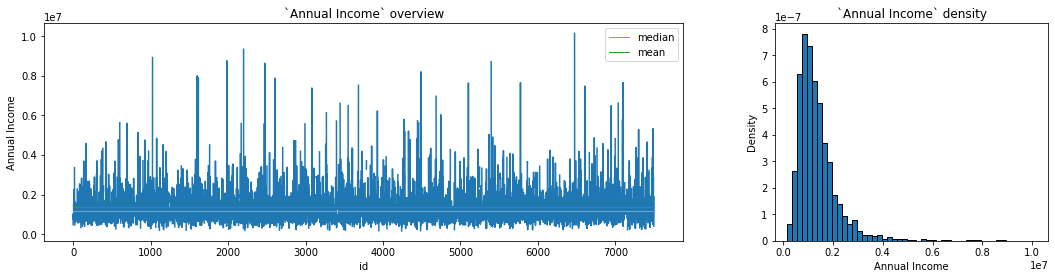

Пропуски: True


In [200]:
overview('Annual Income', size=(18, 4), bins=50, mean=True, median=True)

Визуально вполне ок, но есть пропуски

## Years in current job

In [201]:
print(data['Years in current job'].value_counts())
print(f"Пропуски: {data['Years in current job'].isna().any()}")


10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
Пропуски: True


Перевести в вещественный признак. Также есть пропуски.

In [202]:
X = data.copy()
def years_in_current_job_encode(value: str) -> int:
  result = re.search(r'< (\d*)|(\d*)', value)
  if result.group(1):
    return 0
  elif result.group(2):
    return result.group(2)


X['Years in current job'] = X['Years in current job'].apply(years_in_current_job_encode).astype('float16')


In [203]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   float16 
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

\## Tax Liens

In [204]:
data['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

Можно объединить в dummy "HaveTaxLiens"

## Number of Open Accounts

Пропуски: False


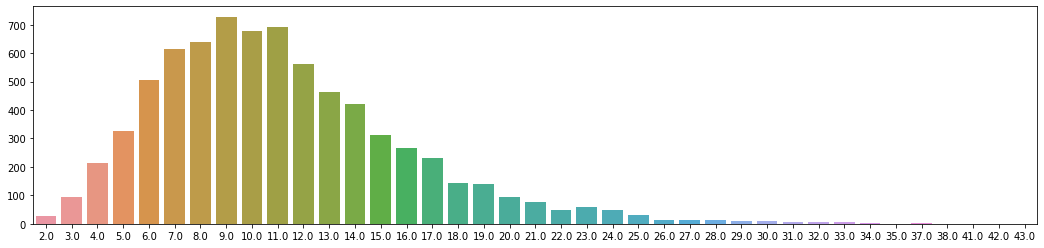

In [205]:
plt.figure(figsize=(18, 4))
sns.barplot(data['Number of Open Accounts'].value_counts().index, data['Number of Open Accounts'].value_counts().values)
print(f"Пропуски: {data['Number of Open Accounts'].isna().any()}")

Визуально ок, пропусков нет

## Years of Credit History

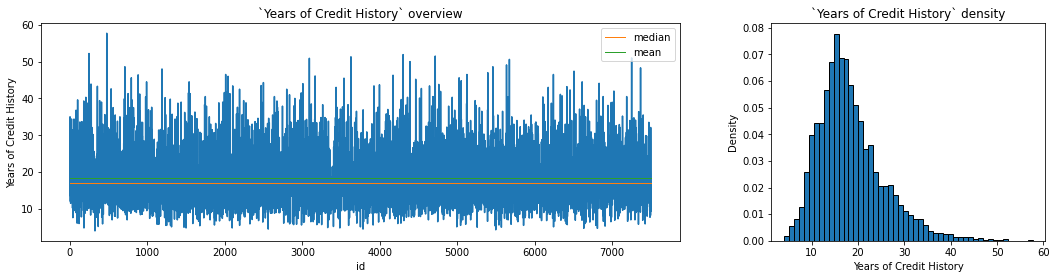

Пропуски: False


In [206]:
overview('Years of Credit History', bins=50, size=(18, 4), median=True, mean=True)

Визуально ок, пропусков нет.

## Maximum Open Credit

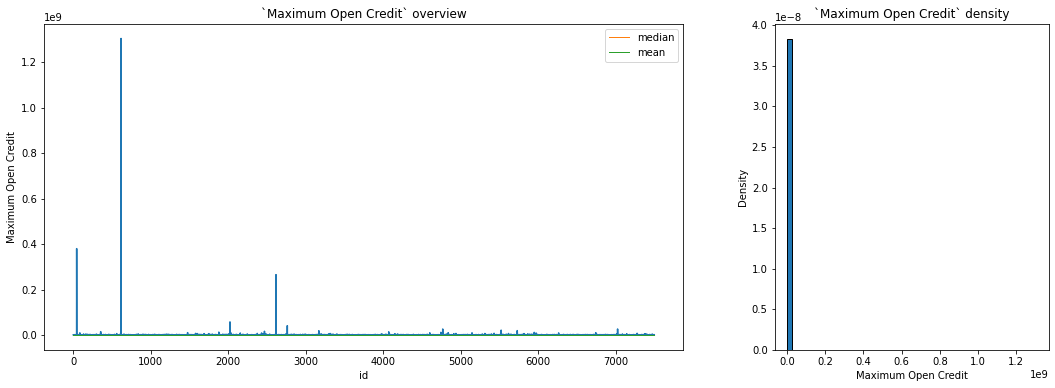

Пропуски: False


In [207]:
overview('Maximum Open Credit', bins=50, size=(18, 6), median=True, mean=True)

порядок 1e9 это может быть выброс, однако он не противоречит логике признака - вполне возможно, что у кого-то очень большой кредит был. А значения == 0, могут быть выбросы, если например Current Loan Amount != 0 или Monthly Debt != 0. Пропусков нет.

In [208]:
# пробую выкинуть и посмотреть, что получится
# data.drop(data.loc[data['Maximum Open Credit'] > 1e8, 'Maximum Open Credit'].index, inplace=True)


## Number of Credit Problems

In [209]:
print(data['Number of Credit Problems'].value_counts())
print(f"Пропуски: {data['Number of Credit Problems'].isna().any()}")


0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64
Пропуски: False


## Months since last delinquent

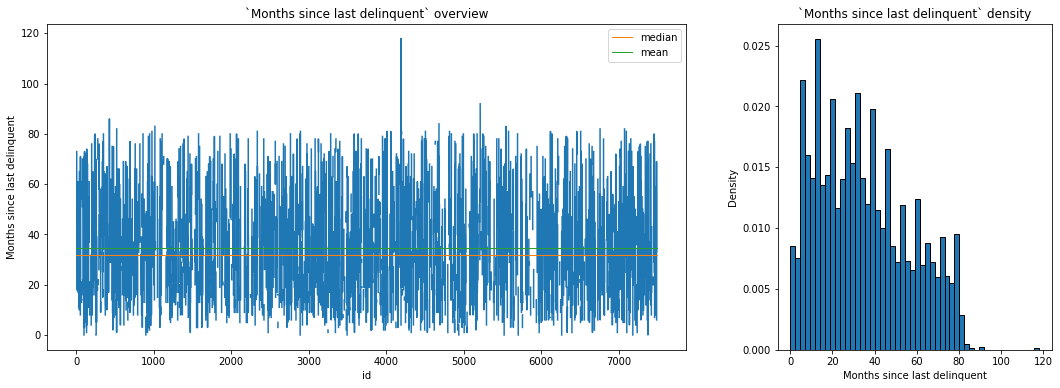

Пропуски: True


In [210]:
overview('Months since last delinquent', bins=50, size=(18, 6), median=True, mean=True)

Значения вполне ок, но больше половины данных - пропуски. Можно интерпретировать пропуск как факт отсутствия в прошлом просрочек по платежам (заполнить -1)

## Bankruptcies

In [211]:
print(data['Bankruptcies'].value_counts())
print(f"Пропуски: {data['Bankruptcies'].isna().any()}")

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64
Пропуски: True


Есть небольшое кол-во пропусков. Можно интерпретировать как отсутствие банкротств (заполнить нулями)

## Purpose

In [212]:
print(data['Purpose'].value_counts())
print(f"Пропуски: {data['Purpose'].isna().any()}")

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
Пропуски: False


Пропусков нет. OneHotEncoder или dummy:
* debt consolidation = 1
* все остальное = 0

## Term

In [213]:
print(data['Term'].value_counts())
print(f"Пропуски: {data['Term'].isna().any()}")

Short Term    5556
Long Term     1944
Name: Term, dtype: int64
Пропуски: False


Пропусков нет. Сделать dummy

## Current Loan Amount

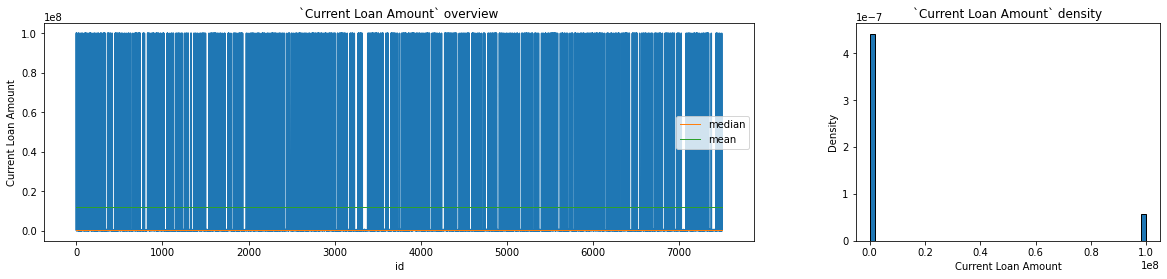

Пропуски: False


In [214]:
overview('Current Loan Amount', bins=50, size=(20, 4), median=True, mean=True)

Пропусков нет. Порядок 1e8, вероятно, выбросы

In [215]:
# пробую выкинуть и посмотреть, что получится
# data.drop(data.loc[data['Current Loan Amount'] > 1e7, 'Current Loan Amount'].index, inplace=True)

## Current Credit Balance

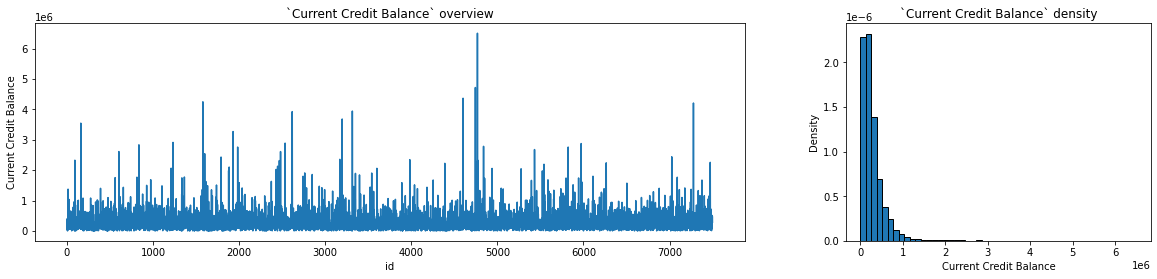

Пропуски: False


In [216]:
overview('Current Credit Balance', bins=50, size=(20, 4))

Пропусков нет. Про выбросы - надо смотреть зависимости от других признаков.

## Monthly Debt

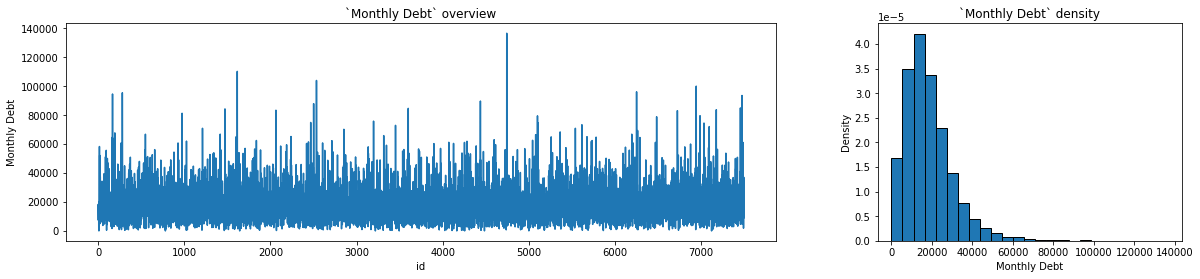

Пропуски: False


In [217]:
overview('Monthly Debt', bins=25, size=(20, 4))

Пропусков нет. Визуально ок.

## Credit Score

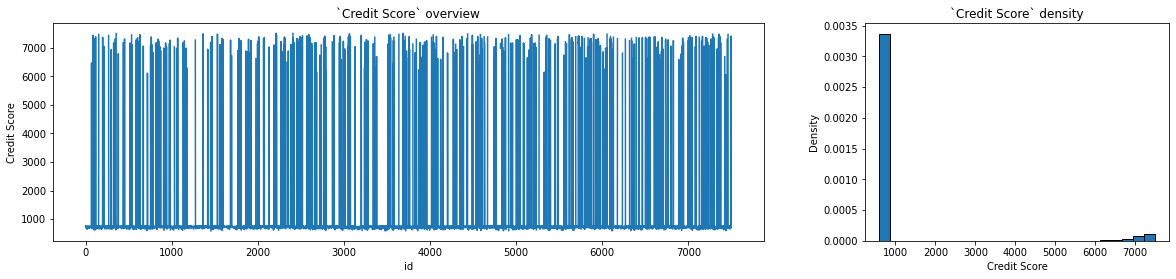

Пропуски: True


In [218]:
overview('Credit Score', bins=25, size=(20, 4))

Есть значительное кол-во пропусков. и много значений over 7k: их можно / 10

In [219]:
# пробую выкинуть и посмотреть, что получится
# data.drop(data.loc[data['Credit Score'] > 1000, 'Credit Score'].index, inplace=True)
# data.loc[data['Credit Score'] > 1000, 'Credit Score'] = data.loc[data['Credit Score'] > 1000, 'Credit Score'].apply(lambda value: value / 10)


## Logical validation of features

In [220]:
# ежемесячный платеж выше наибольшего открытого кредита - наверно, так быть не должно
data[data['Monthly Debt'] > data['Maximum Open Credit']].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,14.0,0.0,debt consolidation,Short Term,165924.0,0.0,9021.0,738.0,0
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,NaN,0.0,small business,Short Term,218042.0,0.0,5855.0,738.0,0
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,NaN,0.0,home improvements,Short Term,108042.0,0.0,30340.0,742.0,0
309,Rent,1245792.0,3 years,0.0,5.0,22.4,0.0,0.0,58.0,0.0,major purchase,Long Term,338096.0,0.0,395.0,659.0,0


In [221]:
# нулевой макс. кредит
data[data['Maximum Open Credit'] == 0].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,14.0,0.0,debt consolidation,Short Term,165924.0,0.0,9021.0,738.0,0
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,NaN,0.0,small business,Short Term,218042.0,0.0,5855.0,738.0,0
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,NaN,0.0,home improvements,Short Term,108042.0,0.0,30340.0,742.0,0
309,Rent,1245792.0,3 years,0.0,5.0,22.4,0.0,0.0,58.0,0.0,major purchase,Long Term,338096.0,0.0,395.0,659.0,0


In [222]:
# нулевой ежемесячный платеж
data[data['Monthly Debt'] == 0].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
780,Home Mortgage,867749.0,10+ years,0.0,2.0,16.5,0.0,0.0,66.0,0.0,home improvements,Short Term,75350.0,0.0,0.0,704.0,0
1643,Rent,NaN,9 years,0.0,3.0,10.0,0.0,0.0,NaN,0.0,other,Short Term,332156.0,0.0,0.0,NaN,1
3219,Home Mortgage,NaN,10+ years,0.0,3.0,18.5,0.0,0.0,NaN,0.0,debt consolidation,Short Term,79200.0,0.0,0.0,NaN,0
3496,Rent,233567.0,1 year,0.0,7.0,11.7,0.0,0.0,0.0,NaN,educational expenses,Short Term,210166.0,0.0,0.0,746.0,0
4165,Rent,1254513.0,10+ years,0.0,6.0,23.4,0.0,0.0,60.0,0.0,take a trip,Short Term,100000000.0,0.0,0.0,748.0,0


Monthly Debt == 0, Maximum Open Credit == 0, но Current Loan Amount != 0 и у одного есть просрочка. Значит, значения Monthly Debt и Maximum Open Credit могут быть некорретны

## Correlations

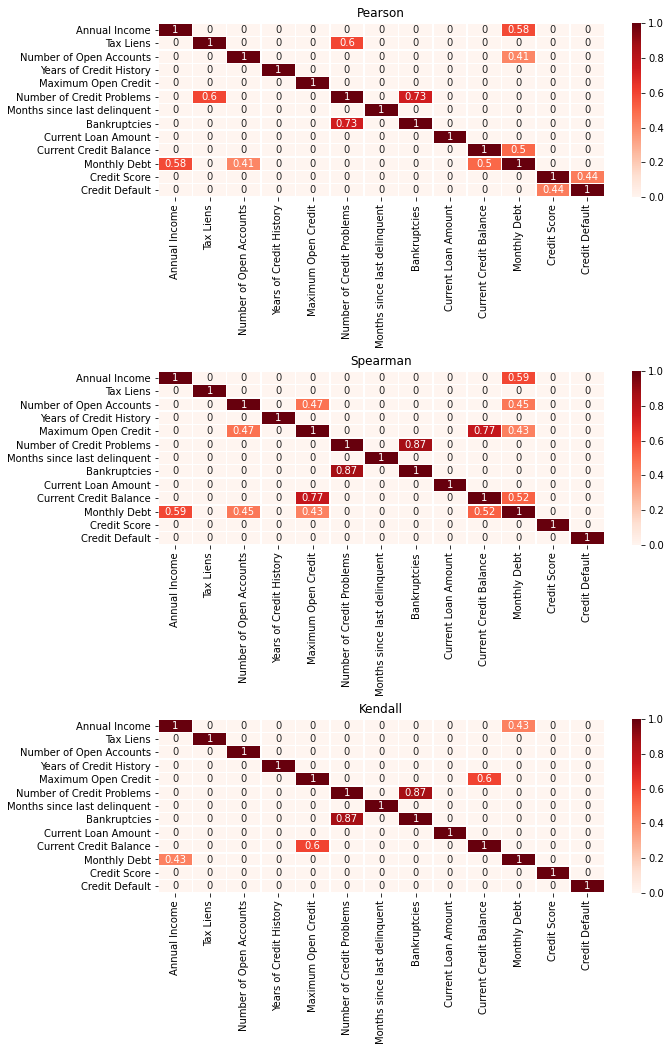

In [223]:
fig, ax = plt.subplots(3, 1, figsize=(10, 16))
plt.subplots_adjust(hspace=1)
corr = data.corr()
corr[abs(corr) < 0.4] = 0
sns.heatmap(corr, lw=0.5, cmap='Reds', annot=True, ax=ax[0])
corr = data.corr('spearman')
corr[abs(corr) < 0.4] = 0
sns.heatmap(corr, lw=0.5, cmap='Reds', annot=True, ax=ax[1])
corr = data.corr('kendall')
corr[abs(corr) < 0.4] = 0
sns.heatmap(corr, lw=0.5, cmap='Reds', annot=True, ax=ax[2])

ax[0].set_title('Pearson')
ax[1].set_title('Spearman')
ax[2].set_title('Kendall')
plt.show()

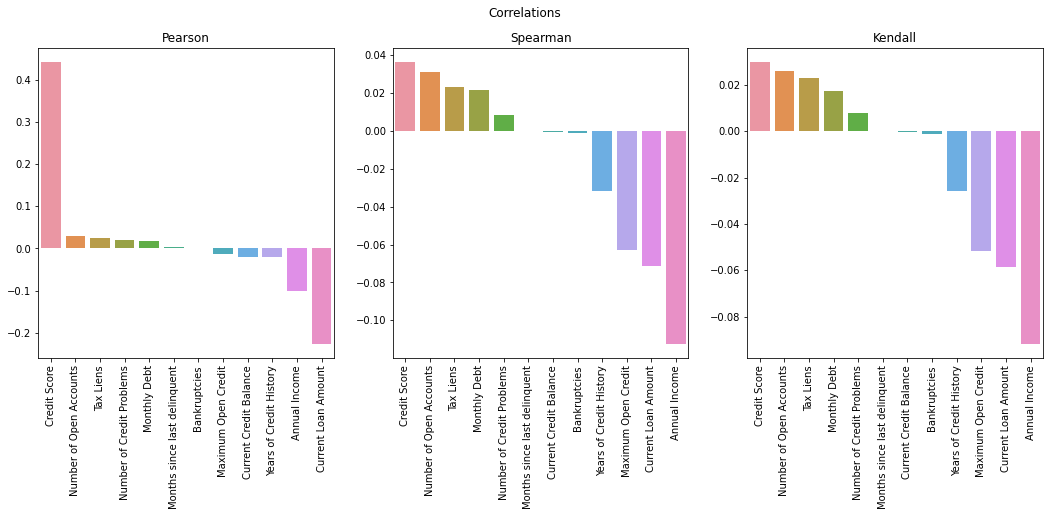

In [224]:
pearson_corr = data.corrwith(data[target], method='pearson').sort_values(ascending=False)
pearson_corr.drop(target, inplace=True)
spearman_corr = data.corrwith(data[target], method='spearman').sort_values(ascending=False)
spearman_corr.drop(target, inplace=True)
kendall_corr = data.corrwith(data[target], method='kendall').sort_values(ascending=False)
kendall_corr.drop(target, inplace=True)

fig, ax = plt.subplots(1, 3, figsize=(18, 5.7))
fig.suptitle('Correlations')
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)
ax[2].tick_params(axis='x', rotation=90)
sns.barplot(pearson_corr.index, pearson_corr, ax=ax[0])
sns.barplot(spearman_corr.index, spearman_corr, ax=ax[1])
sns.barplot(kendall_corr.index, kendall_corr, ax=ax[2])

ax[0].set_title('Pearson')
ax[1].set_title('Spearman')
ax[2].set_title('Kendall')
plt.show()

# **Data correction**

In [225]:
class Preprocessing:
  def __init__(self):
    self.home_ownership_encode = {'Home Mortgage': 0,
                                  'Have Mortgage': 0,
                                  'Rent': -1,
                                  'Own Home': 2}
    # self.purpose_encode = {'debt consolidation': 0,
    #                        'other': 1,
    #                        'home improvements': 2,
    #                        'business loan': 3,
    #                        'buy a car': 4,
    #                        'medical bills': 5,
    #                        'major purchase': 6,
    #                        'take a trip': 7,
    #                        'buy house': 8,
    #                        'small business': 9,
    #                        'wedding': 10,
    #                        'moving': 11,
    #                        'educational expenses': 12,
    #                        'vacation': 13,
    #                        'renewable energy': 14,
    #                        }
    self.medians = None
    self.purpose_dict = None
    self.loan_quantille = None


  def fill_outliers(self, X, feature: str, condition, method='None', value=0, repair_prefix='repaired'):
    """ Fills outliers by condition in column `feature` of dataframe X with selected method.
        If method is None or incorrect - fill with value.
        Also adds data-repaired flag """
    # if X[condition].shape[0] == 0:
      # return
    if repair_prefix:
      X[f'{repair_prefix} {feature}'] = 0
      X.loc[condition, f'{repair_prefix} {feature}'] = 1
    if method != 'model':
      try:
        func = getattr(X.loc[~condition, feature], method)
        X.loc[condition, feature] = func()
      except (AttributeError, TypeError):
        X.loc[condition, feature] = value
    else:   # modeling
      df = X.copy()

      df_X = df[~condition].drop(columns=feature)
      df_y = df.loc[~condition, feature]
      df_predict = df[condition].drop(columns=feature)
      X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, shuffle=True, random_state=47)

      fill_model = XGBRegressor(random_state=19,
                                subsample=0.1,
                                min_child_weight=10,
                                objective='reg:squarederror',
                                max_depth=5,
                                n_estimators=500,
                                learning_rate=0.1,)
      fill_model.fit(X_train, y_train)
      X.loc[condition, feature] = fill_model.predict(df_predict)


  def fillnan(self, X, feature: str, method='None', value=0, repair_prefix='repaired'):
    """ Fills NaN in column `feature` of dataframe X with value. Also adds data-repaired flag """
    self.fill_outliers(X, feature, X[feature].isna(), method, value, repair_prefix)

  def years_in_current_job_encode(self, value: str) -> int:
    """ Encoder for `Years in current job`. Returns 0 for '< 1 years' """
    result = re.search(r'< (\d*)|(\d*)', value)
    if result.group(1):
      return 0
    elif result.group(2):
      return result.group(2)


  def fit(self, X):
    self.medians = X.median()
    purpose_encoder = OneHotEncoder(handle_unknown='ignore')
    purpose_encoder.fit(X[['Purpose']])
    self.purpose_dict = {name: value for value, name in enumerate(purpose_encoder.categories_[0])}

    self.credit_history_max_quantille = X['Years of Credit History'].quantile(0.95)
    self.loan_quantille = X['Current Loan Amount'].quantile(0.9)
    self.score_max = 751;
    self.score_min = 1
    # self.score_min = X['Credit Score'].min()


  def transform(self, X):
    # encode categories
    X['Home Ownership'] = X['Home Ownership'].replace(self.home_ownership_encode).astype('int8')
    X['Years in current job'] = X['Years in current job'].apply(self.years_in_current_job_encode).astype('float16')
    X['Purpose'] = X['Purpose'].map(self.purpose_dict).astype('float16')   # encode source Purpose    
    X['Purpose'].fillna(-1, inplace=True)
    X['Term'] = X['Term'].apply(lambda value: int(value == 'Short Term')).astype('int8')    # Short Term = 0; Long Term = 1;


    # fill NaN
    self.fillnan(X, 'Annual Income', value=self.medians['Annual Income'])
    self.fillnan(X, 'Years in current job', method='median')
    self.fillnan(X, 'Months since last delinquent', value=-1)
    self.fillnan(X, 'Bankruptcies', value=0)

    out_condition = X['Credit Score'] > self.score_max
    X.loc[out_condition, 'Credit Score'].apply(lambda value: value / 10)
    self.fillnan(X, 'Credit Score', method='model')
    # X['Credit Score'].clip(lower=self.score_min, upper=self.score_max, inplace=True)
    # self.fillnan(X, 'Credit Score', value=self.medians['Credit Score'])

    # outliers
    out_condition = X['Maximum Open Credit'] == 0    
    self.fill_outliers(X, 'Maximum Open Credit', out_condition, value=self.medians['Maximum Open Credit'])
    # self.fill_outliers(X, 'Maximum Open Credit', out_condition, method='model')

    out_condition = X['Monthly Debt'] == 0
    self.fill_outliers(X, 'Monthly Debt', out_condition, value=self.medians['Monthly Debt'])
    # self.fill_outliers(X, 'Monthly Debt', out_condition, method='model')

    out_condition = X['Current Loan Amount'] >= self.loan_quantille
    # self.fill_outliers(X, 'Current Loan Amount', out_condition, value=self.medians['Current Loan Amount'])
    self.fill_outliers(X, 'Current Loan Amount', out_condition, method='model')

    # swap if Monthly Debt is more than Maximum Open Credit
    # swap_condition = X['Monthly Debt'] > X['Maximum Open Credit']
    # X['swapped Monthly Debt'] = 0
    # X.loc[swap_condition, 'swapped Monthly Debt'] = 1
    # X.loc[swap_condition, ['Monthly Debt', 'Maximum Open Credit']] = X.loc[swap_condition, ['Maximum Open Credit', 'Monthly Debt']].values

    # X.fillna(self.medians, inplace=True)
    return X

# **Balancing classes**

In [226]:
def balancing(X, y, **params):
  """ ATTENTION! All data must be set to numeric """
  ignored_cols = params.pop('ignored_cols', [])
  ignored_prefix = params.pop('ignored_prefix', [])
  frac = params.pop('frac', 1)    # multiplier for items_counts

  # disbalance = df[target].value_counts()[0] / df[target].value_counts()[1]
  target = y.name
  col_names = X.columns.to_list()
  col_names.append(target)

  # collect ignored columns: these will not be filled in
  ignored = [col for col in X.columns if any([col.startswith(prefix) for prefix in ignored_prefix])]
  ignored.extend(ignored_cols)

  max_count = y.value_counts()[y.value_counts().argmax()]

  ext_df = pd.DataFrame(columns=col_names, dtype='float64')

  # for each class that differs from target
  for cls, count in y.value_counts().items():
    if count == max_count:
      continue

    # create zero dataframe
    items_count = int((max_count - count) * frac)
    cls_ext_df = pd.DataFrame(np.zeros(shape=(items_count, X.shape[1] + 1)), columns=col_names)
    cls_ext_df[target] = cls

    # fill features
    for feat in X.columns:
      if feat in ignored:
        continue
      # generate custom distribution
      xk = X[feat].value_counts().keys().tolist()
      pk = X[feat].value_counts().values / X.loc[X[feat].notna(), feat].shape[0]

      rv = rv_discrete(name='custom', values=(xk, pk), seed=47)
      cls_ext_df[feat] = rv.rvs(size=items_count, random_state=14)

    ext_df = ext_df.append(cls_ext_df, ignore_index=True)      

  return ext_df.drop(columns=[target]), ext_df[target]

Не очень удачный вариант балансировки

# **Featuring**

In [227]:
class Featuring:
  def __init__(self, group_feats=[]):
    self.group_feats = group_feats
    self.medians = None

    self.default_by_purpose = None
    self.default_by_purpose_mode = None
    self.mode_score_default = None

    # self.purpose_encoder = None
    # self.onehot_purpose_names = None
    self.purposes_count = 15


  def fit(self, X, y=None):
    df = X.copy()
    self.medians = X.median()
    if y is not None:
      df['Credit Default'] = y.values

      # Credit Default by Purpose aggregate
      self.default_by_purpose = df.groupby(['Purpose'])['Credit Default'].agg(lambda v: pd.Series.mode(v)[0]).to_dict()

      # Credit Score mode for Credit Default == 1 aggregate
      self.mode_score_default = df.groupby(['Credit Default'])['Credit Score'].agg(lambda v: pd.Series.mode(v)[0])[1]

    # self.purpose_encoder = OneHotEncoder(handle_unknown='ignore')
    # self.purpose_encoder.fit(X[['Purpose']])
    # self.onehot_purpose_names = [f'One Hot Purpose {name}' for name in self.purpose_encoder.categories_[0]]

    # ---------- GROUP FEATURES AGGREGATE ----------
    for mfeat, gfeat in self.group_feats:
      feat_value = X.groupby([gfeat])[mfeat].agg('median').to_dict()
      setattr(self, f'{mfeat}_by_{gfeat}', feat_value)


  def transform(self, X):
    # X['Purpose is debt consolidation'] = X['Purpose'].apply(lambda value: int(value == 'debt consolidation'))                             # Purpose dummy
    # X = X.join(pd.DataFrame(self.purpose_encoder.transform(X[['Purpose']]).toarray(), columns=self.onehot_purpose_names, index=X.index))       # Purpose OneHotEncode

    categories = [f'One Hot Purpose {num}.0' for num in np.arange(0, 15)]
    purpose_dummies = pd.get_dummies(X['Purpose'], prefix='One Hot Purpose', prefix_sep=' ')
    purpose_dummies = purpose_dummies.T.reindex(categories).T.fillna(0)
    X = X.join(purpose_dummies)    

    # Critical Debt Load  
    condition = X['Annual Income'] < X['Monthly Debt'] * 12
    X.loc[condition, 'Critical Debt Load'] = 1
    X.loc[~condition, 'Critical Debt Load'] = 0

    # Income to Debt ratio
    X['Income to Debt ratio'] = np.round((X['Annual Income']/12) / X['Monthly Debt'], 3)
    X.loc[X['Income to Debt ratio'].isna(), 'Income to Debt ratio'] = X['Income to Debt ratio'].median()

    # Income to Loan ratio
    # X['Income to Loan ratio'] = np.round((X['Annual Income']/12) / X['Current Loan Amount'], 3)
    # X.loc[X['Income to Loan ratio'].isna(), 'Income to Loan ratio'] = X['Income to Loan ratio'].median()

    # Количество платежей, обеспеченных годовым доходом
    # X['Number of secured payments'] = X['Annual Income'] / X['Monthly Debt']

    # Ожидаемый срок погашения
    X['Expected Term'] = X['Current Loan Amount'] / X['Monthly Debt']

    # Credit Default by Purpose merge
    # if self.default_by_purpose is not None:
      # X['Default by Purpose'] = X['Purpose'].map(self.default_by_purpose)
    
    # Credit Score delta (minus mode for Credit Default)
    # if self.mode_score_default is not None:
    #   X['Delta Credit Score'] = X['Credit Score'] - self.mode_score_default

    # ---------- GROUP FEATURES MERGE ----------
    for mfeat, gfeat in self.group_feats:
      feat_value = getattr(self, f'{mfeat}_by_{gfeat}', None)
      if feat_value:
        X[f'{mfeat} by {gfeat}'] = X[gfeat].map(feat_value)

    # drop non-meaningful columns
    X.drop(columns=['Purpose'], inplace=True)

    # X.fillna(self.medians, inplace=True)
    return X

In [228]:
# примочка для изучения влияния группированных фичей на качество модели:
# набор фичей можно рассматривать как взвешенный направленный граф, вершины которого - фичи, а веса - изменения метрики F1
# при этом при каждом переходе веса меняются
# Пример использования в блоке Experiments

def features_research(**params):
  mode = params.pop('mode', 'deep')   # deep or wide through features graph
                                      #   deep - take random feature, without researching
                                      #   wide - research all features and take the best
  model_type = params.pop('model_type', 'cross')    # single or cross model to optimize. Searching in both model types is not implemented
  max_depth = params.pop('max_depth', 4)    # maximal nodes count to research
  seed = params.pop('seed', None)
  use_feats = params.pop('start_feats', [])

  gb = ['Home Ownership', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term']
  ft = ['Annual Income', 'Years in current job', 'Years of Credit History', 'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
  features = [(f, g) for g in gb for f in ft]

  # shuffle features if mode == 'deep'
  if mode == 'deep':
    rng = np.random.default_rng(seed)
    # print()
    rng.shuffle(features)

  score = (0.5, 0.5)
  # depth = len(use_feats)
  depth = 0
  prev_score = (0, 0)
  ind = int(model_type == 'cross')
  feats_collection = []

  while depth < max_depth:
    if (mode == 'wide') and (score[ind] - prev_score[ind] <= 0):
      break

    cols = ['single', 'cross']
    feat_report = pd.DataFrame(columns=cols)

    prev_score = score
    for feat in features:
      research_feats = use_feats.copy()
      if feat in research_feats:
        continue
      research_feats.append(feat)
      model = make_model(mode='both',
                        folds=3,
                        features=set(research_feats),
                        silent=True,
                        balance=0.001,
                        cvfrac=0.2,
                        learning_rate=0.025,
                        max_depth=4,
                        n_estimators=300,
                        )
      score = make_model.f1_test_final
      feat_report = feat_report.append(pd.Series(make_model.f1_test_final, index=cols, name=feat))
      if mode == 'deep':
        break

    feat_report['single'].apply(lambda val: val - prev_score[0])
    feat_report['cross'].apply(lambda val: val - prev_score[1])
    feat_report.to_csv(f'feats_research_depth_{depth}.csv')
    use_feats.append(feat_report.iloc[feat_report[model_type].argmax()].name)
    score = feat_report.max()
    depth += 1
    feats_collection.append(use_feats.copy())
    print(f'depth={depth}; f1={score[ind]}; use_feats={use_feats}')
  print(use_feats)
  return feats_collection

# **Prepare datasets**

In [229]:
def prepare_data(X_train_src, y_train_src, X_test_src, **params):
  balance = params.pop('balance', None)
  features = params.pop('features', [])

  X_train = X_train_src.copy()
  y_train = y_train_src.copy()
  X_test = X_test_src.copy()

  # Preprocessing
  preprocessor = Preprocessing()
  preprocessor.fit(X_train)
  X_train = preprocessor.transform(X_train)
  X_test = preprocessor.transform(X_test)

  # Balancing
  if balance:
    X_ext, y_ext = balancing(X_train, y_train, ignored_prefix=['One Hot', 'repaired'], frac=balance)
    X_train = X_train.append(X_ext, ignore_index=True)
    y_train = y_train.append(y_ext, ignore_index=True)

  # Featuring
  featuring = Featuring(features)
  featuring.fit(X_train, y_train)
  X_train = featuring.transform(X_train)
  X_test = featuring.transform(X_test)

  disbalance = int(y_train.value_counts()[0]) / int(y_train.value_counts()[1])
  # print(f'disbalance: {disbalance}')

  return (X_train, y_train, X_test, disbalance)



# **Build classification model**

In [230]:
def make_model(**params):
  runmode = params.pop('mode', 'cross')       # mode to build model: 'single' - return one-time trained model, 'cross' - return cross-trained model, 'both' - return both models
  balance = params.pop('balance', None)       # additional fraction of generated records
  folds = params.pop('folds', 2)              # data folds (= number of models to be built and combined). Learn in non-cross mode if None
  cvfrac = params.pop('cvfrac', 0.2)          # fraction of the main dataset that is separated for final hold-out validation
  features = params.pop('features', [])       # List with pairs of existing features to build new ones. Format is like (feat_to_median, feat_to_groupby)
  silent = params.pop('silent', False)        # don't print anything except the result
  random_state = params.pop('random_state', 21)   # random state for modeling

  # load dataset
  df_train = load_dataset(PATH_TRAIN, silent=silent)

  # get part of the main dataset for final hold-out validation
  X = df_train.drop(columns='Credit Default')
  y = df_train['Credit Default']
  X, X_test_final, y, y_test_final = train_test_split(X, y, test_size=cvfrac, shuffle=True, random_state=11)
  X_train_final, y_train_final, X_test_final, final_disbalance = prepare_data(X, y, X_test_final, balance=balance, features=features)

  # initialize some vars
  singlemodel, crossmodel = None, None
  model_sum = None
  models = []
  models_weights = []
  cols = ['F1 train', 'F1 test', 'F1 train final', 'F1 test final']
  scores = pd.DataFrame(columns=cols)

  # build model(s)
  # ---------- cross mode ----------
  if (runmode == 'cross') or (runmode == 'both'):   # cross-mode
    kf = KFold(n_splits=folds, shuffle=True, random_state=37)
    for num, (train_index, test_index) in enumerate(kf.split(X), 1):
      X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
      y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
    
      X_train, y_train, X_test, disbalance = prepare_data(X_train, y_train, X_test, balance=balance, features=features)
      crossmodel = CatBoostClassifier(logging_level='Silent',
                                      allow_writing_files=False,
                                      class_weights=[1, disbalance],
                                      use_best_model=True,
                                      eval_metric='F1',
                                      random_state=random_state,
                                      **params)
      crossmodel.fit(X_train, y_train, eval_set=(X_test, y_test))
      model_sum = to_classifier(sum_models([model_sum, crossmodel])) if model_sum is not None else crossmodel
      models.append(crossmodel)

      # scoring model
      f1_train, f1_test = f1(y_train, crossmodel.predict(X_train)), f1(y_test, crossmodel.predict(X_test))
      f1_train_final, f1_test_final = f1(y_train_final, crossmodel.predict(X_train_final)), f1(y_test_final, crossmodel.predict(X_test_final))
      scores = scores.append(pd.Series([f1_train, f1_test, f1_train_final, f1_test_final], index=cols, name=f'Model {num}'))
      models_weights.append(f1_test_final)
      # scoring model_sum
      f1_train, f1_test = f1(y_train, model_sum.predict(X_train)), f1(y_test, model_sum.predict(X_test))
      f1_train_final, f1_test_final = f1(y_train_final, model_sum.predict(X_train_final)), f1(y_test_final, model_sum.predict(X_test_final))
      scores = scores.append(pd.Series([f1_train, f1_test, f1_train_final, f1_test_final], index=cols, name=f'Sum Model fold#{num}'))

    # try to set model weights by F1_test_final
    models_weights = np.array(models_weights)
    models_weights = models_weights / np.sum(models_weights)
    # print(models_weights)

    # combine models
    model = to_classifier(sum_models(models, weights=[1/len(models)] * len(models)))
    # model = to_classifier(sum_models(models, weights=models_weights))

    # final scoring
    f1_train_final, f1_test_final = f1(y_train_final, model.predict(X_train_final)), f1(y_test_final, model.predict(X_test_final))
    scores = scores.append(pd.Series([np.nan, np.nan, f1_train_final, f1_test_final], index=cols, name='Cross model'))

  # ---------- single mode ---------
  if (runmode == 'single') or (runmode == 'both'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=11)
    X_train, y_train, X_test, disbalance = prepare_data(X_train, y_train, X_test, balance=balance, features=features)
    singlemodel = CatBoostClassifier(logging_level='Silent',
                                     allow_writing_files=False,
                                     class_weights=[1, disbalance],
                                     use_best_model=True,
                                     eval_metric='F1',
                                     random_state=random_state,
                                     **params)
    singlemodel.fit(X_train, y_train, eval_set=(X_test, y_test))

    # scoring
    f1_train, f1_test = f1(y_train, singlemodel.predict(X_train)), f1(y_test, singlemodel.predict(X_test))
    f1_train_final, f1_test_final = f1(y_train_final, singlemodel.predict(X_train_final)), f1(y_test_final, singlemodel.predict(X_test_final))
    scores = scores.append(pd.Series([f1_train, f1_test, f1_train_final, f1_test_final], index=cols, name=f'Single Model'))

  scores['delta'] = scores['F1 train'] - scores['F1 test']
  scores['delta final'] = scores['F1 train final'] - scores['F1 test final']
  setattr(make_model, 'scores', scores)

  if runmode == 'single':
    setattr(make_model, 'f1_test_final', (scores['F1 test final'].iloc[-1], np.nan))
    return singlemodel
  elif runmode == 'cross':
    setattr(make_model, 'f1_test_final', (np.nan, scores['F1 test final'].iloc[-1]))
    return crossmodel
  elif runmode == 'both':
    setattr(make_model, 'f1_test_final', (scores['F1 test final'].iloc[-1], scores['F1 test final'].iloc[-2]))
    return (singlemodel, crossmodel)

In [231]:
# Different random-state validation
def diff_seed_validation(**params):
  count = params.pop('count', 10)
  cols = ['single', 'cross']
  valid = pd.DataFrame(columns=cols)
  rng = np.random.default_rng()
  for i in range(count):
    rs = rng.integers(1000, endpoint=True)
    model = make_model(random_state=rs,
                       silent=True,
                       **params)
      
    valid = valid.append(pd.Series(make_model.f1_test_final, index=cols, name=str(rs)))
    # print(rs, make_model.f1_test_final)

  valid = valid.append(pd.Series((valid['single'].mean(), valid['cross'].mean()), index=cols, name='mean'))
  print(valid)

# **GridSearchCV**

In [232]:
# %%time
# # load and split dataset
# train_df = load_dataset(PATH_TRAIN)

# X = train_df.drop(columns='Credit Default')
# y = train_df['Credit Default']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=51)
# X_train, y_train, X_test, disbalance = prepare_data(X_train, y_train, X_test, balance=0.001, features=features)

# def_params = {'logging_level': 'Silent',
#               # 'bootstrap_type': 'Bayesian',
#               'allow_writing_files': False,
#               'class_weights': [1, disbalance],
#               'use_best_model': True,
#               'eval_metric': 'F1',
#               'random_state': 21,
              
#               # 'subsample': 0.5,
#               # 'early_stopping_rounds': 30,
#               # 'reg_lambda': 2.617721518987342,
#               # custom_metric=['Precision', 'Recall'],
#           }

# params = {'learning_rate': np.linspace(0.025, 0.2, 9),
#           # 'bootstrap_type': ['MVS', 'Bayesian'],
#           'n_estimators': [100, 200, 300],
#           'max_depth': [4, 5, 6, 7],
#           # 'reg_lambda': np.linspace(0.5, 4, 5)
#           # 'subsample': np.linspace(0.1, 1, 6),
#           # 'min_data_in_leaf': [1, 3, 5],
#           }

# model = CatBoostClassifier(**def_params)
# search = GridSearchCV(estimator=model,
#                       param_grid=params,
#                       scoring='f1',
#                       cv=KFold(n_splits=5, shuffle=True, random_state=49),
#                       n_jobs=-1)
# search.fit(X_train, y_train, eval_set=(X_test, y_test))

In [233]:
# print(search.best_params_)

In [234]:
# # Check params
# model = make_model(mode='both',
#                    folds=3,
#                    features=features,
#                    balance=0.001,
#                    cvfrac=0.2,
#                    **search.best_params_)

# *EXPERIMENTS*

In [235]:
# tdata = load_dataset(PATH_TRAIN)
# tX, ty = tdata.drop(columns=['Credit Default']), tdata['Credit Default']

# pre = Preprocessing()
# pre.fit(tX)
# tX = pre.transform(tX)
# # tX

In [236]:
# post = Featuring(features)
# post.fit(tX, ty)
# tX = post.transform(tX)
# tX

In [237]:
# # grouped features engineering: (median, groupby)
# features = (('Maximum Open Credit', 'Home Ownership'),
#             ('Credit Score', 'Home Ownership'),
#             ('Credit Score', 'Years in current job'),
#             ('Current Loan Amount', 'Purpose'),
#             )

In [238]:
# %%time
# features_collection = features_research(mode='wide', max_depth=2, model_type='cross', start_feats=[('Credit Score', 'Home Ownership')])

In [239]:
# %%time
# features_collection = features_research(mode='deep', max_depth=6, model_type='cross', start_feats=[])

In [240]:
# # MODELING EXPERIMENT
# model = make_model(mode='cross',
#                    folds=3,
#                    features=[('Current Loan Amount', 'Term'), ('Maximum Open Credit', 'Bankruptcies'), ('Credit Score', 'Years in current job')],
#                    balance=0.001,
#                    cvfrac=0.2,
#                    random_state=885,
#                   #  bootstrap_type='Bayesian',
#                    learning_rate=0.025,
#                    max_depth=4,
#                    n_estimators=300,
#                    )
# make_model.scores

In [241]:
# diff_seed_validation(count=20,
#                      mode='cross',
#                      folds=3,
#                      features=features,
#                      balance=0.001,
#                      cvfrac=0.2,
#                     #  learning_rate=0.2,
#                     #  max_depth=3,
#                     #  n_estimators=200,
#                      learning_rate=0.025,
#                      max_depth=4,
#                      n_estimators=300
#                      )

# **Output**

## **Train final model**

In [242]:
# grouped features engineering: (median, groupby)
features = (('Maximum Open Credit', 'Home Ownership'),
            ('Credit Score', 'Home Ownership'),
            ('Credit Score', 'Years in current job'),
            ('Current Loan Amount', 'Purpose'),
            )

In [250]:
# MODELING EXPERIMENT
model = make_model(mode='cross',
                   folds=3,
                   features=features,
                   balance=0.001,
                   random_state=21,
                   cvfrac=0.2,
                   learning_rate=0.025,
                   max_depth=4,
                   n_estimators=300,
                   )
make_model.scores

Memory usage of dataframe is 0.97 MB
Memory usage of dataframe is 0.38 MB
Decreased by 60.9%


,F1 train,F1 test,F1 train final,F1 test final,delta,delta final
Model 1,0.610291,0.552968,0.581142,0.532468,0.057323,0.048675
Sum Model fold#1,0.610291,0.552968,0.581142,0.532468,0.057323,0.048675
Model 2,0.611835,0.545161,0.581999,0.548353,0.066673,0.033647
Sum Model fold#2,0.602564,0.565885,0.588824,0.543879,0.036679,0.044946
Model 3,0.620499,0.553323,0.589143,0.528643,0.067176,0.060500
Sum Model fold#3,0.595609,0.592421,0.591784,0.546032,0.003188,0.045752
Cross model,NaN,NaN,0.591784,0.546032,NaN,0.045752


## **Predictions**

In [251]:
train_df = load_dataset(PATH_TRAIN)
target_df = load_dataset(PATH_TEST)

X_train = train_df.drop(columns='Credit Default')
y_train = train_df['Credit Default']

X_train, y_train, X_target, disbalance = prepare_data(X_train, y_train, target_df, features=features)

print(f'F1 Train (full train dataset): {f1(y_train, model.predict(X_train))}')
y_target = model.predict(X_target)


Memory usage of dataframe is 0.97 MB
Memory usage of dataframe is 0.38 MB
Decreased by 60.9%
Memory usage of dataframe is 0.31 MB
Memory usage of dataframe is 0.13 MB
Decreased by 58.9%
F1 Train (full train dataset): 0.5732318544644515


## **Features correlations**

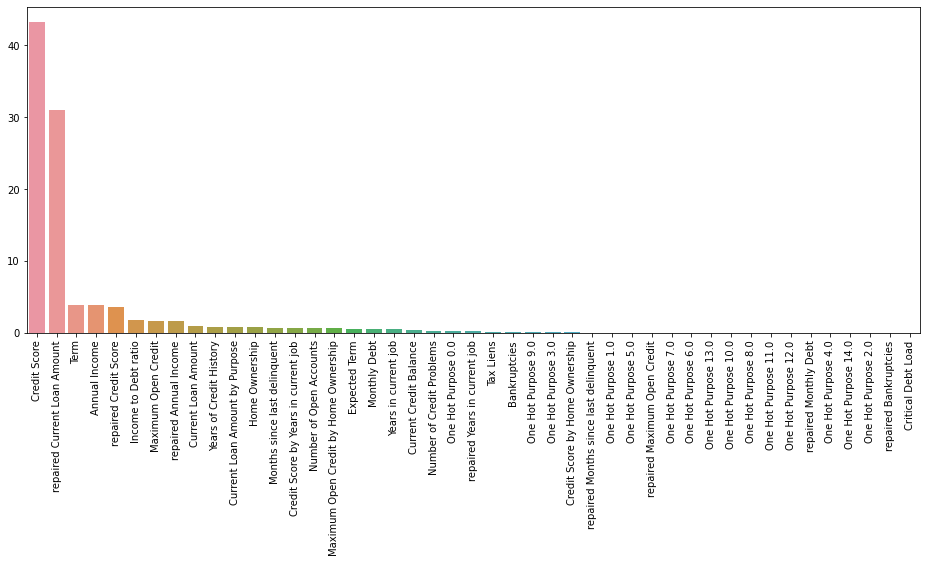

In [245]:
feat_imp = pd.Series(model.feature_importances_, X_train.columns)
feat_imp = feat_imp.sort_values(ascending=False)
plt.figure(figsize=(16, 6))
sns.barplot(feat_imp.index, feat_imp)
plt.xticks(rotation='90')
plt.show()
# feat_imp.sum()

## **Saving**

In [253]:
with open('model.pkl', 'wb') as file:
  pickle.dump(model, file)

with open('model.pkl', 'rb') as file:
  model = pickle.load(file)

pd.DataFrame(y_target, columns=['Credit Default']).to_csv('MirzoianPeter_predictions.csv')

# **Stock**

In [247]:
# # build one model

# def make_model(modelclass, **params):  
#   balance = params.pop('balance', None)       # additional fraction of generated records
#   folds = params.pop('folds', 2)              # data folds (= number of models to be built and combined)
#   cvfrac = params.pop('cvfrac', 0.2)          # fraction of the main dataset that is separated for final hold-out validation
#   features = params.pop('features', [])       # List with pairs of existing features to build new ones. Format is like (feat_to_median, feat_to_groupby)

#   # load dataset
#   df_train = load_dataset(PATH_TRAIN)

#   # get part of the main dataset for final hold-out validation
#   X = df_train.drop(columns='Credit Default')
#   y = df_train['Credit Default']
#   X, X_test_cross, y, y_test_cross = train_test_split(X, y, test_size=cvfrac, shuffle=True, random_state=11)
#   X_train_cross, y_train_cross, X_test_cross, final_disbalance = prepare_data(X, y, X_test_cross, balance=balance)


#   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=11)
#   X_train, y_train, X_test, disbalance = prepare_data(X_train, y_train, X_test, balance=balance)

#   # fit model
#   model = None
#   if modelclass is CatBoostClassifier:
#     model = modelclass(logging_level='Silent',
#                       allow_writing_files=False,
#                       class_weights=[1, disbalance],
#                       use_best_model=True,
#                       eval_metric='F1',
#                       random_state=21,
#                       **params)
#     model.fit(X_train, y_train, eval_set=(X_test, y_test))
#   else:   # это рудимент от тестирования других моделей - пусть живет пока что
#     model = modelclass(#random_state=21,
#                       **params)
#     model.fit(X_train, y_train)

#   # scoring
#   f1_train, f1_test = f1(y_train, model.predict(X_train)), f1(y_test, model.predict(X_test))
#   f1_train_cross, f1_test_cross = f1(y_train_cross, model.predict(X_train_cross)), f1(y_test_cross, model.predict(X_test_cross))

#   f1_delta = f1_train - f1_test
#   f1_delta_cross = f1_train_cross - f1_test_cross
#   print(f'F1  Train: {f1_train}; Test: {f1_test}; delta: {f1_delta}')
#   print(f'F1  Train cross: {f1_train_cross}; Test cross: {f1_test_cross}; delta: {f1_delta_cross}')

#   # print('TRAIN', classification_report(y_train, model.predict(X_train)), sep='\n')
#   # print('TEST', classification_report(y_test, model.predict(X_test)), sep='\n')
#   # print(f'ROC Train: {roc(y_train, model.predict(X_train))}; Test: {roc(y_test, model.predict(X_test))}')
#   # plot_roc_curve(model, X_test, y_test)
#   # plt.show()

# #   return model
#   return model